In [81]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

from pmdarima.arima import auto_arima, arima
from pmdarima.utils import tsdisplay
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
import pmdarima as pm

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## Carregamento e Processamento dos dados

In [3]:
data_2015 = pd.read_csv('dataset/acidentes-transito-2015.csv')
data_2016 = pd.read_csv('dataset/acidentes_2016.csv')
data_2017 = pd.read_csv('dataset/acidentes_2017.csv')
data_2018 = pd.read_csv('dataset/acidentes_2018.csv')
data_2019 = pd.read_csv('dataset/acidentes-2019.csv')

In [4]:
data_2015['data'] = pd.to_datetime(data_2015.data)
#data_2015.set_index(data_2015.data)

In [5]:
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12062 entries, 0 to 12061
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   data                       12062 non-null  object 
 1   hora                       12046 non-null  object 
 2   natureza_acidente          12058 non-null  object 
 3   situacao                   12058 non-null  object 
 4   bairro                     11914 non-null  object 
 5   endereco                   12009 non-null  object 
 6   numero                     6004 non-null   object 
 7   detalhe_endereco_acidente  4311 non-null   object 
 8   complemento                9600 non-null   object 
 9   endereco_cruzamento        11991 non-null  object 
 10  numero_cruzamento          6223 non-null   object 
 11  referencia_cruzamento      9407 non-null   object 
 12  bairro_cruzamento          11888 non-null  object 
 13  num_semaforo               3346 non-null   obj

In [6]:
df_list = [data_2015, data_2016, data_2017, data_2018, data_2019]
df_new_list = []

In [7]:
for i in df_list:
    i['data'] = pd.to_datetime(i.data)
    df_new = i.resample(rule='1D', on='data').agg({'data': 'count'})
    df_new = df_new.rename(columns={'data':'count'})    
    df_new_list.append(df_new)

In [9]:
full_df = pd.concat(df_new_list)

Separação do subconjunto de Treinamento e Teste para modelagem via ARIMA

In [31]:
train= full_df.loc[full_df.index < '2019-01-01']
test_set = full_df.loc[full_df.index > '2019-01-01']

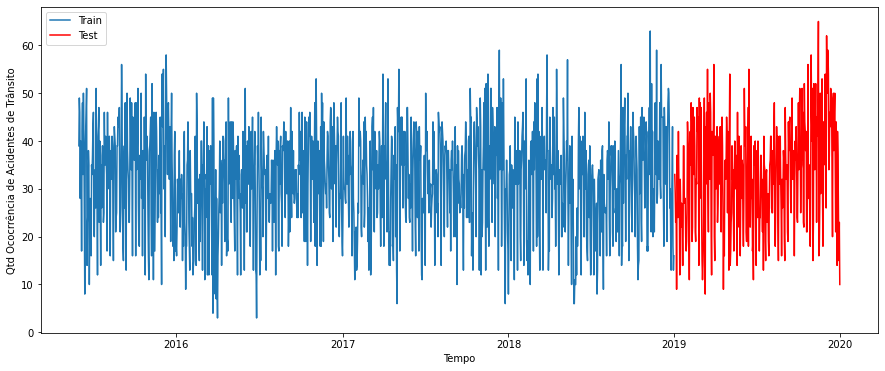

In [34]:
plt.plot(train['count'], label='Train')
plt.plot(test_set['count'], label='Test', color='red')
plt.xlabel('Tempo')
plt.ylabel('Qtd Ococrrência de Acidentes de Trânsito')

plt.legend()

Normalização dos dados. Utilizando scaler para manter dentro do intervalo de 0 e 1

In [22]:
test_size= test_set.shape[0]

In [23]:
serie = full_df['count']
y=serie.values
train_len = len(serie) - test_size

min_max_scaler = MinMaxScaler(feature_range=(0,1))
min_max_scaler.fit(y[0:train_len].reshape(-1, 1))
serie_normalized = min_max_scaler.transform(y.reshape(-1, 1)).flatten()

y_train, y_test = train_test_split(serie_normalized, train_size=train_len)
print("train_size", len(y_train))
print("test_size", len(y_test))

train_size 1311
test_size 364


In [24]:
model = Pipeline(
    [
        (
            "auto - arima",
            pm.AutoARIMA(
                trace=True,
                m=7,
                suppress_warnings=True,
                max_p=100,
                stepwise=True,
                seasonal=True,
            ),
        )
    ]
)

model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=6.60 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-817.133, Time=0.18 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=-1086.948, Time=2.07 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-1022.163, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1966.759, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=-882.743, Time=0.24 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=-1166.606, Time=6.05 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=-1377.483, Time=10.48 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=5.15 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=13.60 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=13.57 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=-1320.956, Time=7.49 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=-1384.137, Time=10.92 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=-1387.835, Time=9.41 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=

Pipeline(steps=[('auto - arima',
                 AutoARIMA(m=7, max_p=100, suppress_warnings=True,
                           trace=True))])

É interessante de se observar que o algoritmo auto_arima corrobora com a estacionariedade da série definida no notebook de Análise Descritiva, onde o parâmetro de diferenciação do modelo selecionado foi 0 e por isso não foi necessário realizar a diferenciação da série que a tornaria estacionária.

In [26]:
def forecast_one_step():
    fc = model.predict(n_periods=1, return_conf_int=False)
    return fc.tolist()[0]
    # np.asarray(conf_int).tolist()[0])

forecasts = []
# confidence_intervals = []

for new_ob in y_test:
    fc = forecast_one_step()
    forecasts.append(fc)
    # confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

0.0314952055620618
0.1425593092687742


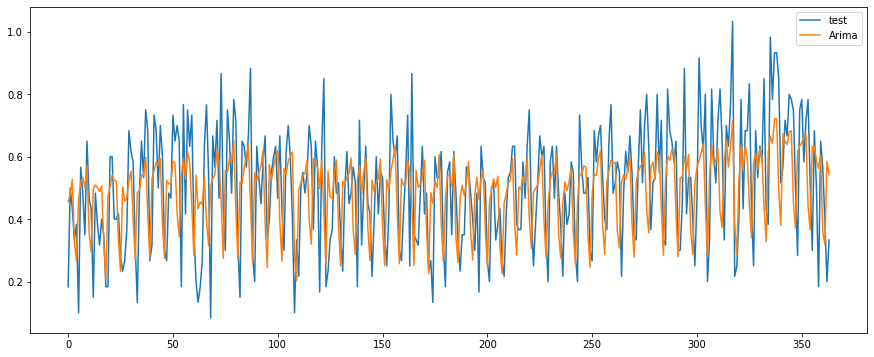

In [96]:
plt.plot(y_test, label='test')
plt.plot(forecasts, label='Arima')
plt.legend()
print(mse(y_test, forecasts))
print(mae(y_test, forecasts))

Modelagem com SVR

Para realizar a modelagem em um algoritmo de aprendizagem de máquina, é necessário transformar os dados para que fiquem em uma estrutura tabular, tendo x como os lags a serem considerados pelo modelo e y o valor a ser previsto.

Outra etapa que se faz necessário em uma modelagem de aprendizagem de máquina é separar o conjunto de validação para se definir os valores dos hiperparâmetros.

In [19]:
test_set = full_df.loc[full_df.index > '2019-01-01']

In [38]:
train= full_df.loc[full_df.index < '2018-01-01']
val= full_df.loc[(full_df.index > '2018-01-01') & (full_df.index < '2019-01-01')]

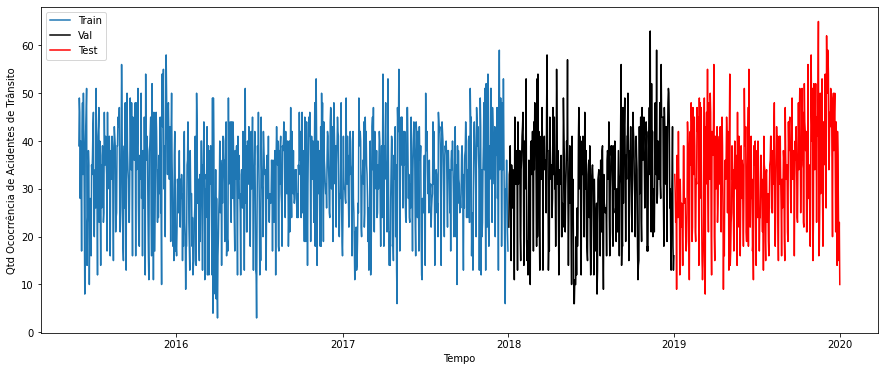

In [39]:
plt.plot(train['count'], label='Train')
plt.plot(val['count'], label='Val', color='black')
plt.plot(test_set['count'], label='Test', color='red')
plt.xlabel('Tempo')
plt.ylabel('Qtd Ococrrência de Acidentes de Trânsito')

plt.legend()

Tabulação dos dados

In [65]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
        
    
    return janelas_np

def split_serie_with_lags(serie, test_size, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]

    y_date = serie[:, -1] 
    print('xdate',x_date.shape)       
       
    train_size_temp = (serie.shape[0]- test_size)
    #train_size = train_size.astype(int)
    print('ts',train_size_temp)
    if perc_val > 0:        
        val_size = np.fix(train_size_temp *perc_val).astype(int)
        train_size= train_size_temp-val_size
        print(train_size,test_size,val_size)

        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):,:]
        y_test = y_date[(train_size+val_size):]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:int(train_size_temp),:]
        y_train = y_date[0:int(train_size_temp)]

        x_test = x_date[int(train_size_temp):-1,:]
        y_test = y_date[int(train_size_temp):-1]

        return x_train, y_train, x_test, y_test


In [69]:
serie_normalized = gerar_janelas(tam_janela=30, serie=serie_normalized)

In [70]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(serie=serie_normalized, test_size=test_size, perc_val=0.25)

xdate (1644, 30)
ts 1280
960 364 320
Particao de Treinamento: 0 960
Particao de Validacao: 960 1280
Particao de Teste: 1280 1644


Para realizar o treinamento do modelo de aprendizagem de máquina é utilizada uma função para realizar a busca dos hiperparametros do modelo e a quantidade de lags ideal à ser utilizada.

In [88]:
def train_svr(
    x_train,
    y_train,
    x_val,
    y_val,
    num_exec=50,
    kernels=['rbf','linear'],
    max_iteracoes=[100],
    gammas=[1, .01],
    Cs=[.1, 1, 10],
    epsilons=[.1, .01],
    ):
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf

    total = len(max_iteracoes)*len(kernels)*num_exec*len(gammas)*len(Cs)
    total = total*len(epsilons)*(int(x_train.shape[1]/2)-1)
    count = 0
    suffix = ''
    lags_results = np.full(int(x_train.shape[1]/2), np.inf)

    for kernel in kernels:
        for gamma in gammas:
            for C in Cs:
                for epsilon in epsilons:
                    for m in range(0,len(max_iteracoes)):
                        for lag in range(1, int(x_train.shape[1]/2)): #variar a qtd de pontos utilizados na janela
                            qtd_lag = lag*2
                            for e in range(0, num_exec):
                                progress_bar(count, total, prefix='train SVR', suffix=suffix)
                                count += 1

                                model = SVR(
                                    kernel=kernel,
                                    gamma=gamma,
                                    C=C,
                                    epsilon=epsilon,
                                )

                                model.fit(x_train[:,-qtd_lag:], y_train)
                                predict_validation = model.predict(x_val[:,-qtd_lag:])
                                mse = MSE(y_val, predict_validation)

                                if mse < best_result:
                                    best_result = mse
                                    suffix = 'Melhor MSE: %.10f'%(best_result)
                                    select_model = model
                                    qtd_lags_sel = qtd_lag

                                if mse < lags_results[lag]:
                                    lags_results[lag] = mse

    progress_bar(total, total, prefix='train SVR', suffix=suffix)
    lags_results = lags_results[1:]

    # print(select_model.coef_)

    return select_model, qtd_lags_sel, lags_results

In [89]:
def progress_bar (
    iteration,
    total,
    prefix = '',
    suffix = '',
    decimals = 1,
    length = 100,
    fill = '#',
    printEnd = '\r'
    ):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    if iteration >= total:
        print()


In [100]:
""" treinar """
model, lag_sel, lags_results = train_svr(
    x_train,
    y_train,
    x_val,
    y_val,
    num_exec=50,

)


In [91]:
pred_test = model.predict(x_test[:, -lag_sel:])

In [92]:
print(mse(y_test, pred_test))
print(mae(y_test, pred_test))

0.023489746973556245
0.11789630515607674


0.023489746973556245
0.11789630515607674


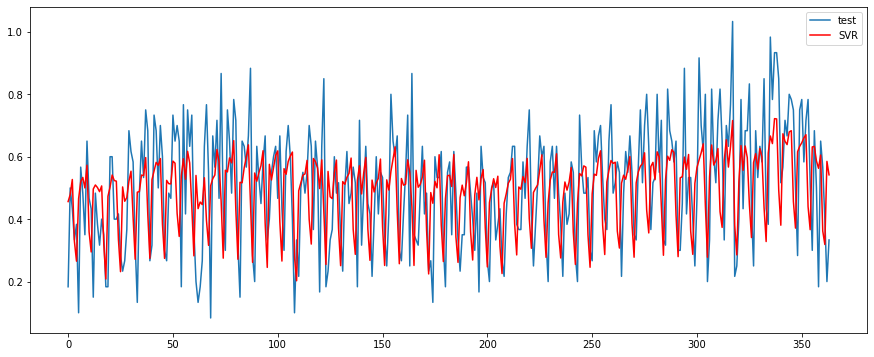

In [94]:
plt.plot(y_test, label='test')
plt.plot(forecasts, label='SVR', color='red')
plt.legend()
print(mse(y_test, pred_test))
print(mae(y_test, pred_test))

Parametros Encontrados

In [97]:
lag_sel

26

In [99]:
model.get_params()

{'C': 0.1,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.01,
 'gamma': 1,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

2.5
É possível adicionar outras variáveis para ajudar no processo de
previsão? Quais? melhoraram os resultados?

É possivel avaliar as demais variáveis presentes no dataset e incluilas como variáveis exógenas ou realizar um procedimento de feature engineering para encontrar variáveis que possam aumentár a assertividade do modelo.